# Model Explanations 

We provide feature importance for model explanations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
import joblib
from sklearn.inspection import permutation_importance
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data and Model Import

In [2]:
data = pd.read_csv('data/data.csv')

Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
data['Clim_zone'] = data['Clim_zone'].astype('category')
data['Coastal?']  = data['Coastal?'].astype('category')

In [4]:
model_cuhi_d = joblib.load('models/CUHI_day_summer_xgb_estimator.joblib') 
model_cuhi_n = joblib.load('models/CUHI_night_summer_xgb_estimator.joblib')
model_suhi_d = joblib.load('models/SUHI_day_summer_xgb_estimator.joblib') 
model_suhi_n = joblib.load('models/SUHI_night_summer_xgb_estimator.joblib') 

In [5]:
features = ['Built Area (%)', 'Grass Area (%)', 'Tree Area (%)', 
            'Albedo_Built', 'Albedo_Grass', 'Albedo_Tree', 
            'DEM_urb_CT_act', 'Clim_zone', 'Coastal?']
labels = ['CUHI_day_summer', 'CUHI_night_summer', 'SUHI_day_summer', 'SUHI_night_summer']

In [6]:
Xy = data.dropna().copy()[features+labels]

## Permutation Importance

In [7]:
titles = ['CUHI (Day)', 'CUHI (Night)', 'SUHI (Day)', 'SUHI (Night)']
yticks = ['Built Area', 'Grass Area', 'Tree Area', 'Built Albedo', 'Grass Albedo', 'Tree Albedo', 
          'Elevation', 'Climate Zone', 'Coastal?']

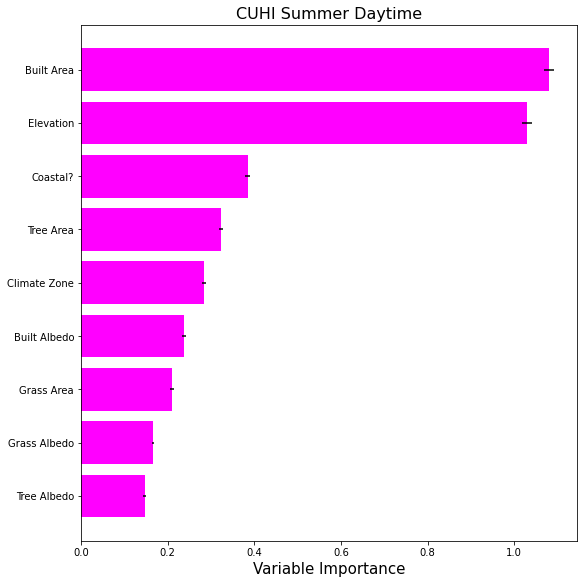

In [8]:
plt.rcParams.update({'font.size': 14})
N_REPEATS = 100
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
y = 'CUHI_day_summer'
result = permutation_importance(model_cuhi_d, Xy[features], Xy[y], n_repeats=N_REPEATS, 
                                scoring='explained_variance', random_state=0, n_jobs=2)
importance_df = pd.DataFrame({
        "feature": yticks,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
})
importance_df = importance_df.sort_values(by='importance_mean', ascending=True)
ax.barh(importance_df['feature'], importance_df['importance_mean'], 
        xerr=importance_df['importance_std'], align='center', color='magenta')
ax.set_xlabel("Variable Importance", fontsize=15)
ax.set_title('CUHI Summer Daytime', fontsize=16)
#plt.suptitle("Permutation Importance", fontsize=18)
plt.savefig('graphs/variable_importance/importance_cuhi_day_variables.png', bbox_inches='tight', dpi=720)

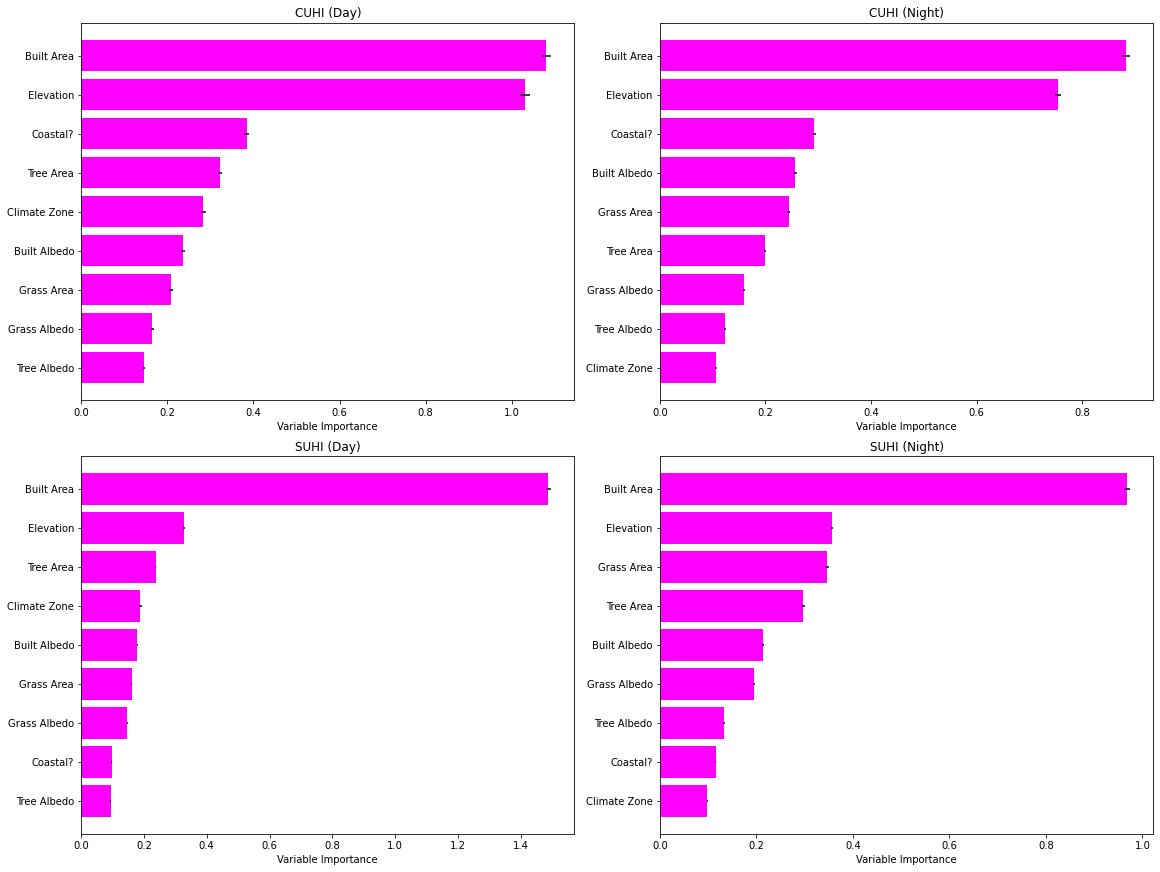

In [9]:
models = [model_cuhi_d, model_cuhi_n, model_suhi_d, model_suhi_n]
titles = ['CUHI (Day)', 'CUHI (Night)', 'SUHI (Day)', 'SUHI (Night)']

N_REPEATS = 100; nrows = 2; ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 12), constrained_layout=True)
for k, ax in enumerate(axes.flatten()):
    y = labels[k]
    result = permutation_importance(models[k], Xy[features], Xy[y], n_repeats=N_REPEATS, 
                                    scoring='explained_variance', random_state=0, n_jobs=2)
    importance_df = pd.DataFrame({
        "feature": yticks,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    })
    importance_df = importance_df.sort_values(by='importance_mean', ascending=True)
    ax.barh(importance_df['feature'], importance_df['importance_mean'], 
            xerr=importance_df['importance_std'], align='center', color='magenta')
    ax.set_xlabel("Variable Importance")
    ax.set_title(titles[k])
#plt.suptitle("Permutation Importance", fontsize=18)
plt.savefig('graphs/variable_importance/importance_all_variables.png', bbox_inches='tight', dpi=720)

## SHAP Values

In [10]:
X = Xy[features].copy()

In [11]:
feature_names = ['Built Area', 'Grass Area', 'Tree Area', 
                 'Built Albedo', 'Grass Albedo', 'Tree Albedo', 
                 'Elevation', 'Climate Zone', 'Coastal']

In [12]:
X.rename(columns=dict(zip(features, feature_names)), inplace=True)

### CUHI Day SHAP Plots

In [13]:
explainer = shap.TreeExplainer(model_cuhi_d, approximate=True)
shap_values = explainer(X)

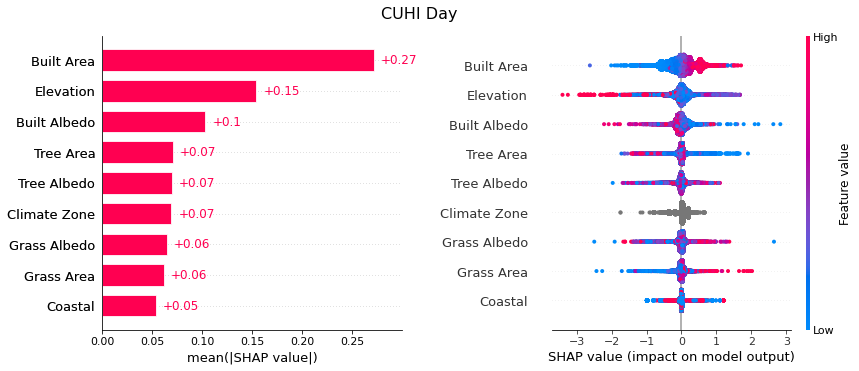

In [14]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(
    shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(
    shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.3, 
    top=0.9,
    wspace = 0.5)

plt.suptitle('CUHI Day', x=1.55, horizontalalignment='center', fontsize=16)
plt.savefig('graphs/shap/cuhi_day.png', bbox_inches='tight', dpi=1280)

### Nighttime CUHI SHAP Plots

In [15]:
explainer = shap.TreeExplainer(model_cuhi_n, approximate=True)
shap_values = explainer(X)

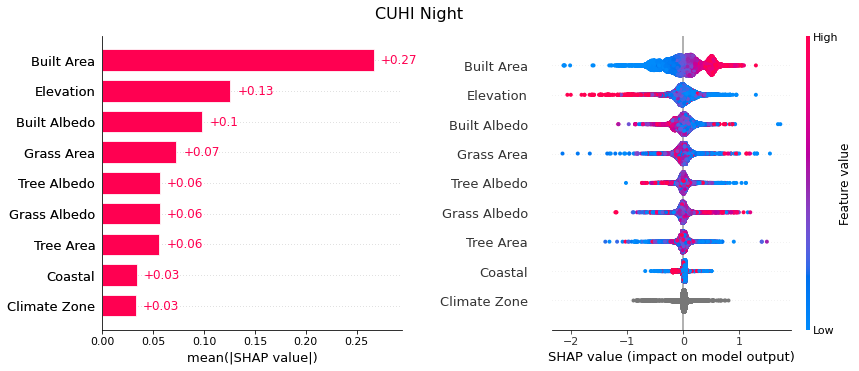

In [16]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(
    shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(
    shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.3, 
    top=0.9,
    wspace = 0.5)

plt.suptitle('CUHI Night', x=1.55, horizontalalignment='center', fontsize=16)
plt.savefig('graphs/shap/cuhi_night.png', bbox_inches='tight', dpi=1280)

### Daytime SUHI SHAP Plots

In [17]:
explainer = shap.TreeExplainer(model_suhi_d, approximate=True)
shap_values = explainer(X)

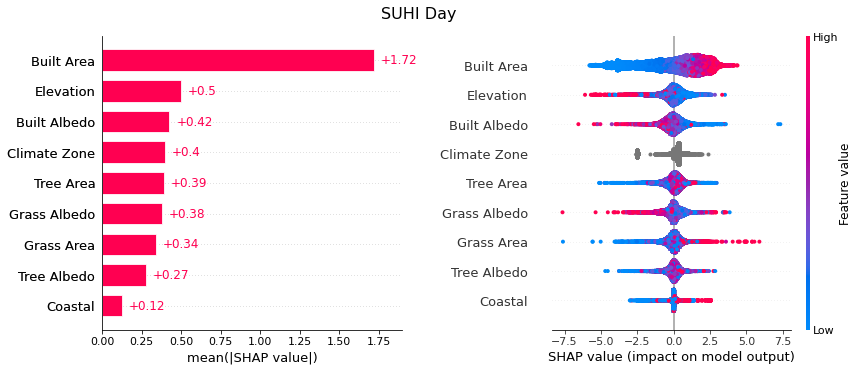

In [18]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(
    shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(
    shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.3, 
    top=0.9,
    wspace = 0.5)

plt.suptitle('SUHI Day', x=1.55, horizontalalignment='center', fontsize=16)
plt.savefig('graphs/shap/suhi_day.png', bbox_inches='tight', dpi=1280)

### Nighttime SUHI SHAP Plots

In [19]:
explainer = shap.TreeExplainer(model_suhi_n, approximate=True)
shap_values = explainer(X)

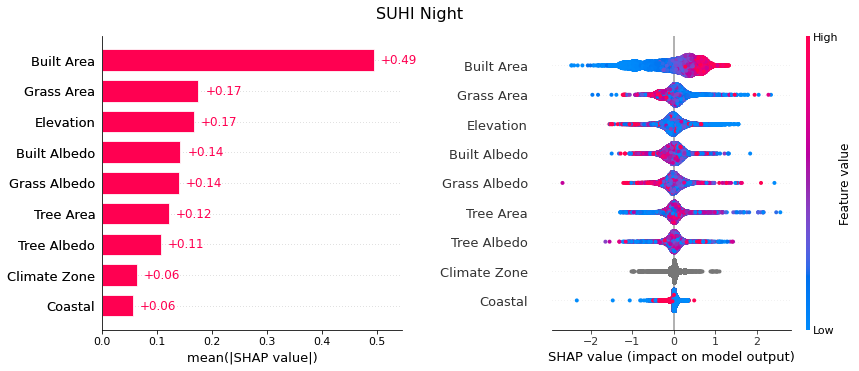

In [20]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(
    shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(
    shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.3, 
    top=0.9,
    wspace = 0.5)

plt.suptitle('SUHI Night', x=1.55, horizontalalignment='center', fontsize=16)
plt.savefig('graphs/shap/suhi_night.png', bbox_inches='tight', dpi=1280)